In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [2]:
# Download dataset (FashionMNIST)
training_data = datasets.FashionMNIST(
    root='../data',
    train=True,
    download=False,
    transform=ToTensor()
)

testing_data = datasets.FashionMNIST(
    root='../data',
    train=False,
    download=False,
    transform=ToTensor()
)

In [3]:
batch_size = 64

# Create the Dataloader
train_dataloader = DataLoader(training_data, batch_size = batch_size)
test_dataloader = DataLoader(testing_data, batch_size = batch_size)


In [4]:
for X, y in test_dataloader:
    print(f'Shpae of X [N, C, H, W] : {X.shape}')
    print(f'Shape of y : {y.shape}, {y.dtype}')
    break

Shpae of X [N, C, H, W] : torch.Size([64, 1, 28, 28])
Shape of y : torch.Size([64]), torch.int64


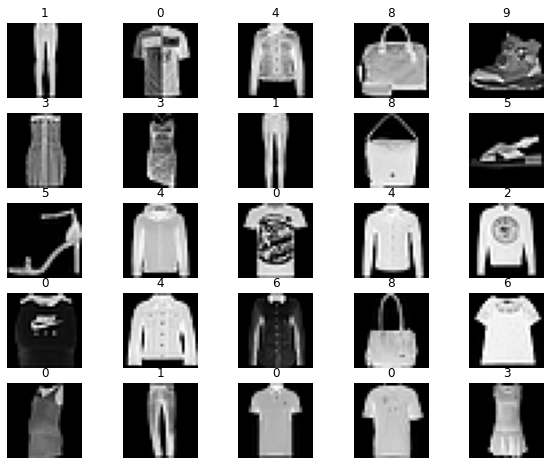

In [5]:
# Display sample data

fig = plt.figure(figsize=(10 ,8))
cols, rows = 5, 5

for i in range(1, cols * rows + 1):
    idx = torch.randint(len(testing_data), size = (1,)).item()
    img, label = testing_data[idx]
    fig.add_subplot(rows, cols, i)
    plt.title(label = label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [6]:
# Get cpu or gpu device for training 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [7]:
# Define model

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linearSeq = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linearSeq(x)
        return logits

In [8]:
model = NeuralNetwork().to(device = device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linearSeq): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [9]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [11]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 2.300708  [    0/60000]
loss: 2.290925  [ 6400/60000]
loss: 2.273067  [12800/60000]
loss: 2.272513  [19200/60000]
loss: 2.258348  [25600/60000]
loss: 2.239854  [32000/60000]
loss: 2.255262  [38400/60000]
loss: 2.228296  [44800/60000]
loss: 2.232110  [51200/60000]
loss: 2.210504  [57600/60000]
Test Error: 
 Accuracy: 48.3%, Avg loss: 0.034523 

Epoch 2
-------------------------------
loss: 2.209653  [    0/60000]
loss: 2.203376  [ 6400/60000]
loss: 2.140853  [12800/60000]
loss: 2.158680  [19200/60000]
loss: 2.138736  [25600/60000]
loss: 2.086895  [32000/60000]
loss: 2.129354  [38400/60000]
loss: 2.069615  [44800/60000]
loss: 2.086281  [51200/60000]
loss: 2.012767  [57600/60000]
Test Error: 
 Accuracy: 47.8%, Avg loss: 0.031660 

Epoch 3
-------------------------------
loss: 2.051352  [    0/60000]
loss: 2.039022  [ 6400/60000]
loss: 1.905090  [12800/60000]
loss: 1.935704  [19200/60000]
loss: 1.919584  [25600/60000]
loss: 1.837894  [32000/600

In [13]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = testing_data[0][0], testing_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_addmm)